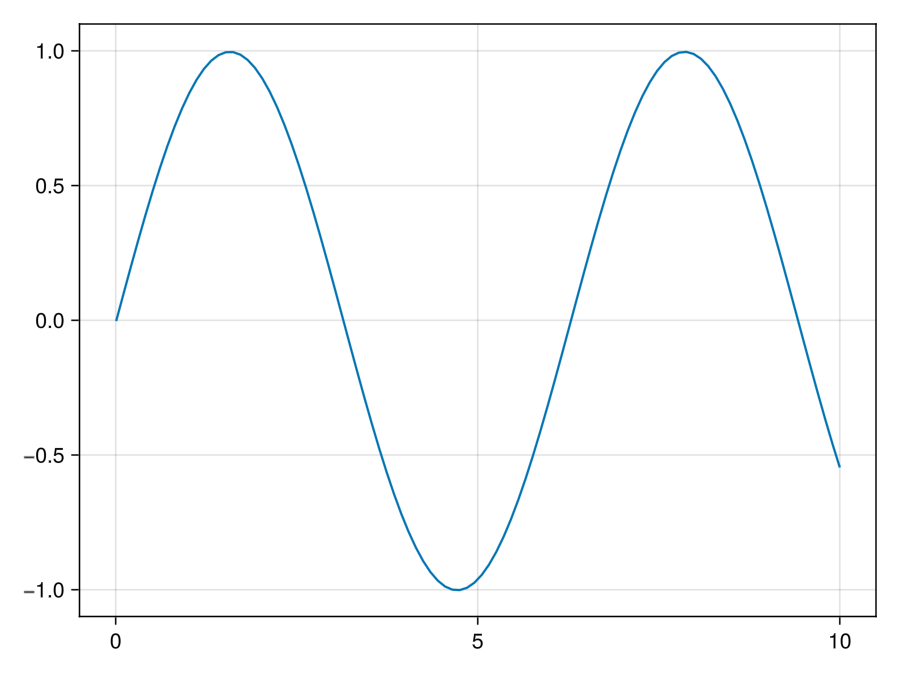

In [2]:
using GLMakie

x = range(0, 10, length=100)
y = sin.(x)
lines(x, y)

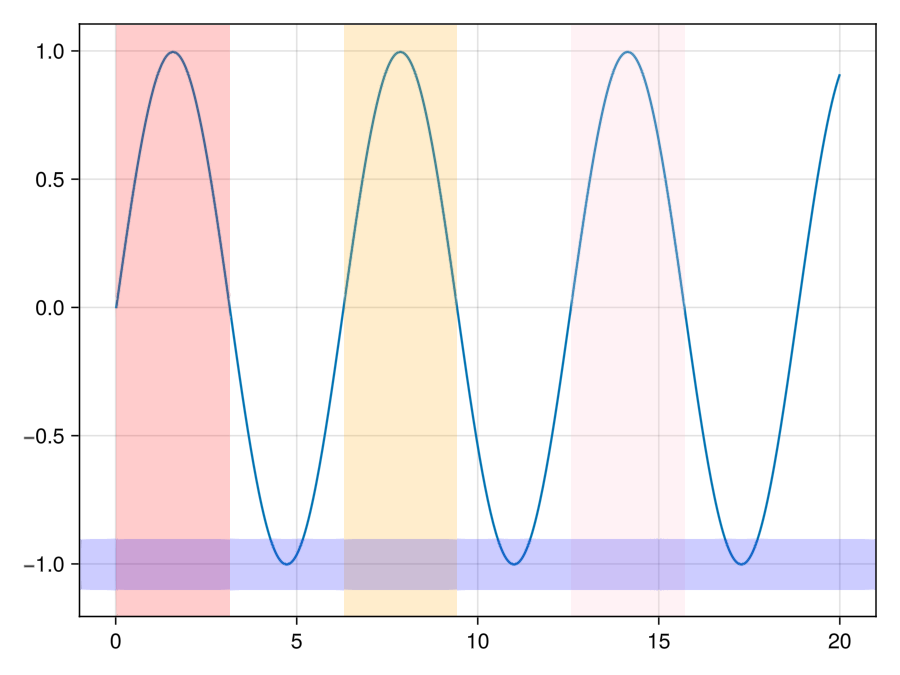

In [3]:

lines(0..20, sin)
vspan!([0, 2pi, 4pi], [pi, 3pi, 5pi],
color = [(c, 0.2) for c in [:red, :orange, :pink]])
hspan!(-1.1, -0.9, color = (:blue, 0.2))
current_figure()